# 🧠 Q-Learning Test on QQQ ETF
This notebook downloads QQQ ETF data and applies a simple Q-learning agent for a test run using binary trend state.


In [31]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set QQQ CSV path (one level above this notebook)
qqq_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'QQQ.csv'))
os.makedirs(os.path.dirname(qqq_path), exist_ok=True)

print("Reading manually exported Yahoo CSV...")

# Read Yahoo-exported CSV (skip first two header rows)
df = pd.read_csv(qqq_path, skiprows=2)

# Rename columns to standard format
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Parse date and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)

# Keep relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Add scaled volume feature: today's volume relative to 10-day average
df['volume_scaled'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
df['volume_scaled'] = df['volume_scaled'].fillna(1)

print("Cleaned data preview:")
df.head()


Reading manually exported Yahoo CSV...
Cleaned data preview:


,Open,High,Low,Close,Volume,volume_scaled
Date,,,,,,
2018-01-02,156.559998,158.529999,156.169998,158.490005,32573300,1.0
2018-01-03,158.639999,160.169998,158.610001,160.029999,29383600,1.0
2018-01-04,160.580002,160.789993,160.080002,160.309998,24776100,1.0
2018-01-05,161.070007,162.029999,160.770004,161.919998,26992300,1.0
2018-01-08,161.919998,162.630005,161.860001,162.550003,23159100,1.0


## 🧮 Define Features and Trend Labels
We'll use a very simple setup:  
- `prev_trend = 1` if price went up yesterday  
- `label = 1` if price goes up tomorrow  
Perfect for simple Q-learning state/action mapping.


In [32]:
# Compute daily return and label: 1 if price will rise tomorrow
df['return'] = df['Close'].pct_change()
df['label'] = (df['return'].shift(-1) > 0).astype(int)

# Feature 1: Previous trend — 1 if yesterday's return > 0, else 0
df['prev_trend'] = (df['return'] > 0).astype(int).shift(1)

# Feature 2: Scaled volume — already added in previous block, shift to avoid lookahead
df['volume_scaled_shifted'] = df['volume_scaled'].shift(1)

# Feature 3: Momentum — 3-day rolling average return, shifted to avoid future info
df['momentum'] = df['return'].rolling(window=3).mean().shift(1)

# Drop rows with NaN (caused by pct_change, rolling, shifting)
df = df.dropna()

# Preview final features to use in state
df[['label', 'prev_trend', 'volume_scaled_shifted', 'momentum']].tail()


,label,prev_trend,volume_scaled_shifted,momentum
Date,,,,
2023-12-22,1,1.0,0.944570,0.000628
2023-12-26,1,1.0,0.729472,-0.000576
2023-12-27,0,1.0,0.503130,0.006418
2023-12-28,0,1.0,0.719662,0.003042
2023-12-29,0,0.0,0.649735,0.002382


## 🤖 Q-Learning Agent
Simple agent that learns via a Q-table with 2 states and 2 actions.


In [33]:
class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.q_table = np.zeros((state_size, action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (target - predict)

    def decay(self):
        self.epsilon *= self.epsilon_decay


## 🏋️ State Encoder

In [34]:
def encode_state(row):
    """
    Convert continuous features into discrete state buckets.
    Input: row from DataFrame with columns: prev_trend, volume_scaled_shifted, momentum
    Output: tuple (trend_bin, volume_bin, momentum_bin)
    """

    # Trend is already 0 or 1
    trend_bin = int(row['prev_trend'])

    # Discretize volume_scaled: 0 = low, 1 = normal, 2 = high
    if row['volume_scaled_shifted'] < 0.8:
        volume_bin = 0
    elif row['volume_scaled_shifted'] > 1.2:
        volume_bin = 2
    else:
        volume_bin = 1

    # Discretize momentum: 0 = downtrend, 1 = neutral, 2 = uptrend
    if row['momentum'] < -0.001:
        momentum_bin = 0
    elif row['momentum'] > 0.001:
        momentum_bin = 2
    else:
        momentum_bin = 1

    return (trend_bin, volume_bin, momentum_bin)


## Train

In [ ]:
class QLearningAgent:
    def __init__(self, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.q_table = {}  # Q[state_tuple] = [value_for_action_0, value_for_action_1]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0] * self.action_size
        return self.q_table[state]

    def act(self, state):
        q_values = self.get_q_values(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        return int(np.argmax(q_values))

    def learn(self, state, action, reward, next_state):
        current_q = self.get_q_values(state)[action]
        max_future_q = max(self.get_q_values(next_state))
        target = reward + self.gamma * max_future_q
        self.q_table[state][action] += self.alpha * (target - current_q)

    def decay(self):
        self.epsilon *= self.epsilon_decay

# Initialize the agent
agent = QLearningAgent(action_size=2)

# Store total reward per epoch
rewards_history = []

# Run training over 30 epochs
for epoch in range(300):
    total_reward = 0

    for i in range(len(df) - 1):
        state = encode_state(df.iloc[i])
        next_state = encode_state(df.iloc[i + 1])

        action = agent.act(state)
        label = df.iloc[i]['label']
        reward = 1 if action == label else -1

        agent.learn(state, action, reward, next_state)
        total_reward += reward

    agent.decay()
    rewards_history.append(total_reward)
    print(f"Epoch {epoch+1}: total reward = {total_reward}, epsilon = {agent.epsilon:.4f}")



Epoch 1: total reward = -38, epsilon = 0.9950
Epoch 2: total reward = 12, epsilon = 0.9900
Epoch 3: total reward = -2, epsilon = 0.9851
Epoch 4: total reward = 34, epsilon = 0.9801
Epoch 5: total reward = 52, epsilon = 0.9752
Epoch 6: total reward = 20, epsilon = 0.9704
Epoch 7: total reward = -14, epsilon = 0.9655
Epoch 8: total reward = 22, epsilon = 0.9607
Epoch 9: total reward = 92, epsilon = 0.9559
Epoch 10: total reward = -12, epsilon = 0.9511
Epoch 11: total reward = -20, epsilon = 0.9464
Epoch 12: total reward = -32, epsilon = 0.9416
Epoch 13: total reward = 96, epsilon = 0.9369
Epoch 14: total reward = -30, epsilon = 0.9322
Epoch 15: total reward = 10, epsilon = 0.9276
Epoch 16: total reward = 4, epsilon = 0.9229
Epoch 17: total reward = 50, epsilon = 0.9183
Epoch 18: total reward = 24, epsilon = 0.9137
Epoch 19: total reward = -36, epsilon = 0.9092
Epoch 20: total reward = 30, epsilon = 0.9046
Epoch 21: total reward = 18, epsilon = 0.9001
Epoch 22: total reward = -32, epsilon

## last

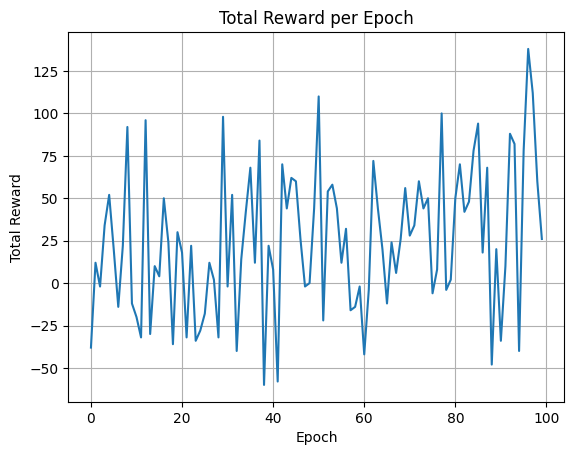

In [ ]:
plt.plot(rewards_history)
plt.title("Total Reward per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.grid(True)
plt.plot(pd.Series(rewards_history).rolling(window=5).mean())
plt.show()
